## Import libraries

In [1263]:
from neo4j import GraphDatabase
import networkx as nx
import numpy as np
from itertools import combinations, islice, product, combinations_with_replacement

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV
from pymoo.visualization.scatter import Scatter
from pymoo.termination.default import DefaultMultiObjectiveTermination

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Set configuration parameters

In [1250]:
URI = "bolt://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "modenapass"


OBJS_NOTIME = ["green_area_weight"]#, "foot_class"]
OBJS_TIME = []#["crash_risk_density_norm"]
TIME_INTERVAL = 0 # one of the following values: {NIGHT: 0, MORNING: 1, AFTERNOON: 2, EVENING: 3}

N_OBJS = len(OBJS_NOTIME+OBJS_TIME)

USER_PREF = [0.5, 0.3, 0.2]

N_CANDIDATE_PATHS = 1000

MODE = "FOOT" # FOOT or BIKE

In [1400]:
URI = "bolt://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "ferrarapass"

OBJS_NOTIME = ["distance", "green_area_weight", "foot_class"]
OBJS_TIME = ["pm25"]
TIME_INTERVAL = 1 # one of the following values: {NIGHT: 0, MORNING: 1, AFTERNOON: 2, EVENING: 3}

N_OBJS = len(OBJS_NOTIME+OBJS_TIME)

USER_PREF = [0.7, 0.1, 0.1, 0.1]

N_CANDIDATE_PATHS = 1000

MODE = "FOOT" # FOOT or BIKE

## 1. Connect to the graph database

In [1403]:
try:
    driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))
    
    session = driver.session()
    if(MODE=="FOOT"):
        node_label="FootNode"
        allowed="pedestrian_allowed_grafmove"
    elif(MODE=="BIKE"):
        node_label="BikeNode"
        allowed="cyclist_allowed_grafmove"
    else:
        raise Exception("Choose FOOT or BIKE as MODE")
        
    query = """MATCH (n:"""+node_label+""")-[r:ROUTE]->(m:"""+node_label+""") 
               where n."""+allowed+"""='yes' 
               and m."""+allowed+"""='yes' 
               RETURN n, r, m"""
    graph_data = session.run(query, node_label=node_label, allowed=allowed)
    
    G = nx.DiGraph()
    for record in graph_data:
        n, r, m = record["n"], record["r"], record["m"]
        G.add_node(n.get("id"), **dict(n))
        G.add_node(m.get("id"), **dict(m))
        G.add_edge(n.get("id"), m.get("id"), **dict(r))
    
    print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")

except Exception as e:
    print(f"Error: {e}")
finally:
    driver.close() if 'driver' in locals() else None

Nodes: 34661, Edges: 67296


## 2. Find candidate paths

In [1405]:
def get_candidate_paths(G, source, target, num_paths=10):
    paths = []
    for obj in OBJS_NOTIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj))
    for obj in OBJS_TIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj[TIME_INTERVAL]))
    for _ in range(num_paths - N_OBJS):
        random_path = nx.shortest_path(G, source, target, weight=lambda u, v, d: torch.rand(1).item())
        paths.append(random_path)
        
    return paths


def get_all_simple_paths(G, source, target):
    paths = []
    for obj in OBJS_NOTIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj))
    for obj in OBJS_TIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj[TIME_INTERVAL]))
    simple_paths = nx.all_simple_paths(G, source, target)
    simple_paths_list = list(simple_paths)
    # simple_paths_list = list(islice(simple_paths, 100))  # just first 100 paths
    paths.append(simple_paths_list)
    
    return paths


# def get_candidate_paths_with_combinations(G, source, target):
#     paths = []
#     for obj in OBJS:
#         paths.append(nx.shortest_path(G, source, target, weight=obj))
# 
#     values = [i / 100 for i in range(101)]
#     combinations = [(a, b, c) for a, b, c in product(values, repeat=3) if round(a + b + c, 2) == 1.00]
#     print(f"Number of combinations: {len(combinations)}")
# 
#     for c in combinations:
#         path = nx.shortest_path(G, source, target, weight=lambda u, v, attrs: attrs[OBJS[0]]*c[0] + attrs[OBJS[1]]*c[1] + attrs[OBJS[2]]*c[2])
#         paths.append(path)
#     return paths

def get_candidate_paths_with_combinations(G, source, target):
    paths = []
    for obj in OBJS_NOTIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj))
    for obj in OBJS_TIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj[TIME_INTERVAL]))

    values = [i / pow(10, N_OBJS) for i in range(pow(10, N_OBJS)+1)]
    combinations = [combo for combo in product(values, repeat=N_OBJS) if round(sum(combo), 2) == 1.00]
    print(f"Number of combinations: {len(combinations)}")

    for c in combinations:
        path = nx.shortest_path(G, source, target, weight=lambda u, v, attrs: sum(attrs[OBJS[obj_index]]*c[obj_index] for obj_index in range(n_objs)))
        paths.append(path)
    return paths

In [1406]:
%%time
# Ferrara
# paths = get_candidate_paths(G, source="1150817556", target="2093992765", num_paths=500)
# paths = get_all_simple_paths(G, source="1150817556", target="1835929247")
# paths = get_candidate_paths_with_combinations(G, source="1150817556", target="2093992765")

# paths = get_candidate_paths(G, source="958004696", target="259040297", num_paths=N_CANDIDATE_PATHS)
paths = get_candidate_paths(G, source="2211349960", target="1836899403", num_paths=N_CANDIDATE_PATHS)
# Modena
# paths = get_candidate_paths(G, source="10053840073", target="2041913868", num_paths=N_CANDIDATE_PATHS)
# paths = get_candidate_paths(G, source="250846426", target="256411970", num_paths=N_CANDIDATE_PATHS)
# paths = get_all_simple_paths(G, source="122021994", target="121994408")
# paths = get_candidate_paths_with_combinations(G, source="122021994", target="121994408")

#paths = get_candidate_paths(G, source="250850846", target="2021402066", num_paths=N_CANDIDATE_PATHS)

CPU times: total: 39.9 s
Wall time: 41.1 s


In [1407]:
print(f"Number of paths: {len(paths)}")

Number of paths: 1000


In [1408]:
no_duplicates = []

for element in paths:
    if(element not in no_duplicates):
        no_duplicates.append(element)

In [1409]:
print(f"Number of non duplicated paths: {len(no_duplicates)}")

Number of non duplicated paths: 695


In [1410]:
# def evaluate_path(G, path):
#     distance = 0
#     green_area_lenght = 0
#     pm25_per_meter = 0
#     for i in range(len(path) - 1):
#         u, v = path[i], path[i+1]
#         distance += G.edges[u, v]["distance"]
#         if(G.edges[u, v]["green_area"]==100):
#             green_area_lenght += G.edges[u, v]["distance"]
#         pm25_per_meter += G.edges[u, v]["pm25_per_meter"] if "pm25_per_meter" in G.edges[u, v] else 0
#         
#     return distance, green_area_lenght, pm25_per_meter/distance
# 
# path_data = []
# for path in no_duplicates:
#     d, g, p = evaluate_path(G, path)
#     path_data.append({"path": path, "distance": d, "green_area_lenght": g, 'avg_pm25_per_meter': p})

In [1411]:
def evaluate_path(G, path):
    eval_objs = {}

    for obj in OBJS_NOTIME:
        eval_objs[obj] = 0
    for obj in OBJS_TIME:
        eval_objs[obj] = 0
            
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        
        for obj in OBJS_NOTIME:
            eval_objs[obj] += G.edges[u, v][obj]
        for obj in OBJS_TIME:
            value = float(G.edges[u, v][obj][0])
            eval_objs[obj] += value
        
    return eval_objs

path_data = []
for path in no_duplicates:
    eval_objs = evaluate_path(G, path)
    eval_objs["path"] = path
    path_data.append(eval_objs)

In [1412]:
print(f"Number of evaluated paths: {len(path_data)}")

Number of evaluated paths: 695


In [1413]:
count=0
for p in path_data:
    if(p["distance"]==p["green_area_weight"]):
        count+=1
print(count)

654


## 3. Find the Pareto Front

In [1414]:
class RoutingProblem(Problem):
    def __init__(self, path_data):
        self.path_data = path_data
        super().__init__(n_var=1, n_obj=N_OBJS, n_constr=0, xl=0, xu=len(path_data) - 1)

    def _evaluate(self, X, out, *args, **kwargs):
        objs = []
        for i in X:
            idx = int(i[0])
            objs.append([self.path_data[idx][obj] for obj in OBJS_NOTIME+OBJS_TIME])
        out["F"] = np.array(objs)

In [1415]:
# class RoutingProblem(Problem):
#     def __init__(self, path_data):
#         self.path_data = path_data
#         super().__init__(n_var=1, n_obj=3, n_constr=0, xl=0, xu=len(path_data) - 1)
# 
#     def _evaluate(self, X, out, *args, **kwargs):
#         objs = []
#         for i in X:
#             idx = int(i[0])
#             objs.append([self.path_data[idx]["distance"], self.path_data[idx]["green_area_weight"], self.path_data[idx]["pm25_per_meter"]])
#         out["F"] = np.array(objs)

In [1416]:
%%time

termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)

problem = RoutingProblem(path_data)
algorithm = NSGA2(pop_size=10000) #len(path_data))
res = minimize(problem, algorithm, verbose=True, termination=termination)

pareto_front = res.F
pareto_solutions = [path_data[int(idx)] for idx in res.X]

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |    10000 |    867 |             - |             -
     2 |    20000 |   1743 |  0.000000E+00 |             f
     3 |    30000 |   2752 |  0.000000E+00 |             f
     4 |    40000 |   3942 |  0.000000E+00 |             f
     5 |    50000 |   5353 |  0.000000E+00 |             f
     6 |    60000 |   6895 |  0.000000E+00 |             f
     7 |    70000 |   8782 |  0.000000E+00 |             f
     8 |    80000 |  10000 |  0.000000E+00 |             f
     9 |    90000 |  10000 |  0.000000E+00 |             f
    10 |   100000 |  10000 |  0.000000E+00 |             f
CPU times: total: 1min 34s
Wall time: 1min 37s


<timed exec>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [1417]:
print(f"Number of solutions in pareto front: {len(pareto_solutions)}")

Number of solutions in pareto front: 10000


In [1418]:
pareto_solutions

[{'distance': 4524.98982023919,
  'green_area_weight': 3799.7040678315193,
  'foot_class': 267,
  'pm25': 1852.4705426248463,
  'path': ['2211349960',
   '2211349953',
   '2211349974',
   '2211349883',
   '2211349888',
   '2211349897',
   '258611683',
   '2211285081',
   '258611722',
   '258611743',
   '258612442',
   '2489155110',
   '258701172',
   '258613814',
   '258613815',
   '258613832',
   '258613810',
   '258614007',
   '258613935',
   '258613888',
   '258613886',
   '258613934',
   '258613889',
   '258612104',
   '1258754589',
   '2218408520',
   '258613969',
   '258613973',
   '2218408599',
   '2393712255',
   '2218408563',
   '1235745270',
   '258701217',
   '1235745415',
   '2125104555',
   '2125104549',
   '2125104465',
   '2125104511',
   '2125104513',
   '2125104536',
   '6305807381',
   '4504823249',
   '2125104446',
   '2125104435',
   '2125104546',
   '2125104438',
   '2125104444',
   '2125104447',
   '2125104448',
   '2125104520',
   '2125104452',
   '2125104455',
 

In [1419]:
count=0
tot_path=""
for p_sol in pareto_solutions:
    path = "python utils/path_utils.py --neo4jURL neo4j://localhost:7687 --neo4juser neo4j --neo4jpwd modenapass --points \""
    for id in p_sol['path']:
        path+=id+" "
    path+="\" --map_filename maps/example_"+str(count)+".html; "
    # print(path)
    tot_path+=path
    count+=1

In [668]:
distance_values_modena = [data['distance'] for _, _, data in G.edges(data=True) if 'distance' in data]

In [675]:
distance_values_ferrara = [data['distance'] for _, _, data in G.edges(data=True) if 'distance' in data]

In [686]:
max(distance_values_modena)

734.1075096486438

C:\Users\feder\AppData\Local\Temp\ipykernel_2704\1303942652.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplots = ax.boxplot(


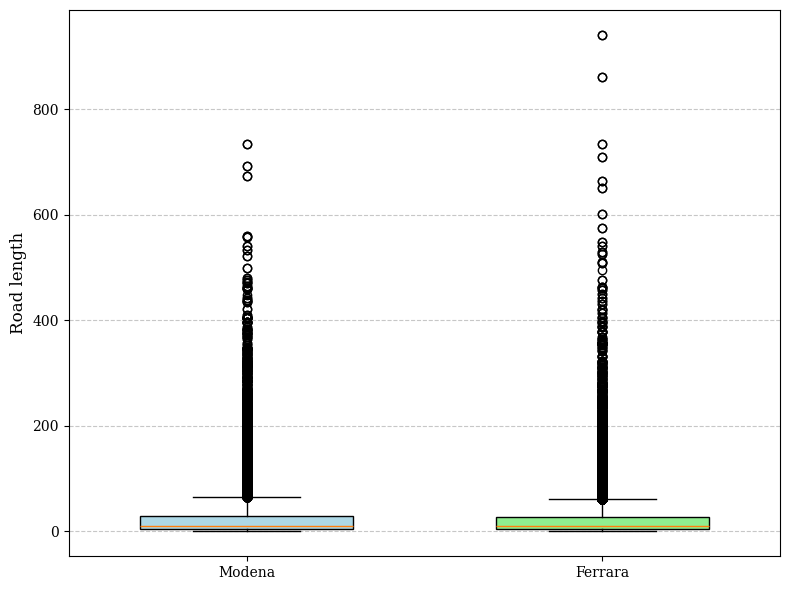

In [682]:
fig, ax = plt.subplots(figsize=(8, 6))

# Creazione dei boxplot affiancati
boxplots = ax.boxplot(
    [distance_values_modena, distance_values_ferrara],
    labels=["Modena", "Ferrara"],  # Etichette sull'asse x
    patch_artist=True,            # Abilita colore riempimento
    widths=0.6                   # Larghezza dei box
)

# Personalizzazione dei colori
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

# Aggiunta di titoli e labels
# ax.set_title('Confronto tra Modena e Ferrara', fontsize=14)
ax.set_ylabel('Road length', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

C:\Users\feder\AppData\Local\Temp\ipykernel_2704\3465053780.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, cmap='viridis', marker='o')


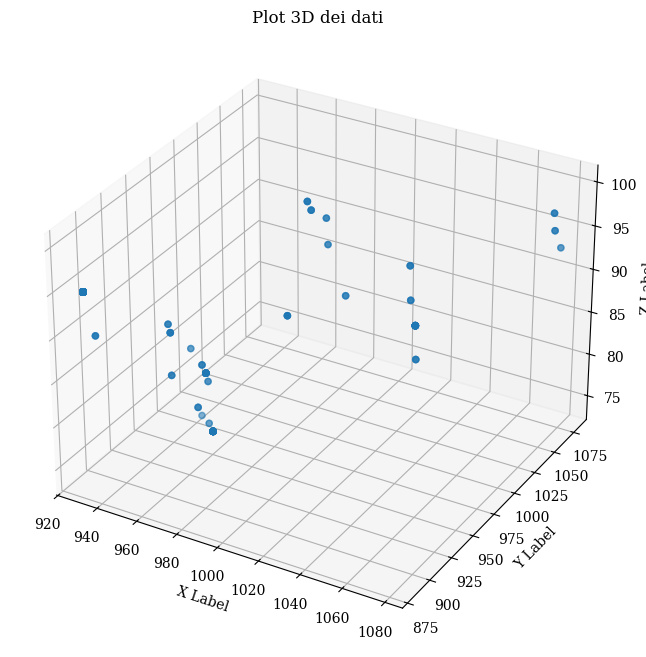

In [1032]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = pareto_front[:, 0]  # Prima colonna
y = pareto_front[:, 1]  # Seconda colonna
z = pareto_front[:, 2]  # Terza colonna

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, cmap='viridis', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('Plot 3D dei dati')
plt.show()

C:\Users\feder\AppData\Local\Temp\ipykernel_2704\3540216505.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, cmap='viridis', marker='o')


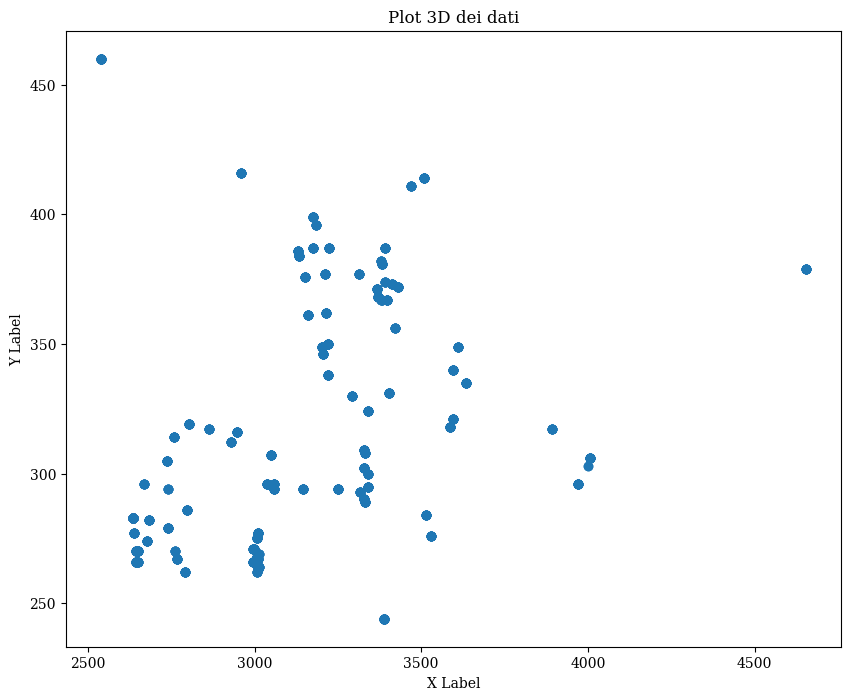

In [270]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Estrai le colonne
x = pareto_front[:, 1]  # Prima colonna
y = pareto_front[:, 2]  # Seconda colonna

# Crea la figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

# Crea lo scatter plot
scatter = ax.scatter(x, y, cmap='viridis', marker='o')

# Aggiungi etichette agli assi
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

# Mostra il plot
plt.title('Plot 3D dei dati')
plt.show()

In [440]:
pareto_solutions[0]['distance']

3536.3926394978344

In [274]:
import pandas as pd

distances = []
green_areas = []
pm25_per_meter = []

for sol in path_data:
    distances.append(sol['distance'])
    green_areas.append(sol['green_area_weight'])
    #pm25_per_meter.append(sol['pm25_per_meter'])

dict_values = pd.DataFrame({'distances': distances, 'green_areas': green_areas})

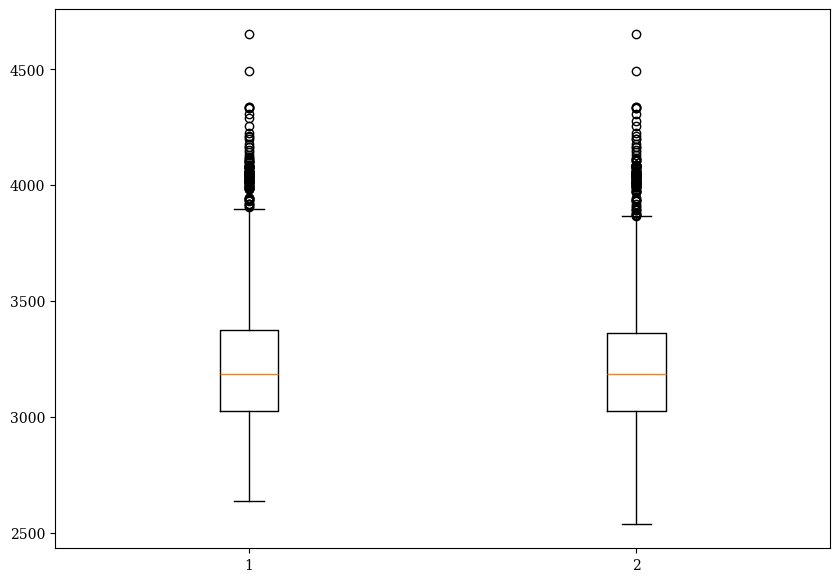

In [276]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))

plt.boxplot(dict_values)
plt.show()

In [1]:
plt.scatter([d["distance"] for d in path_data], [s["green_area_weight"] for s in path_data], color="blue")
plt.scatter([s["distance"] for s in pareto_solutions], [s["green_area_weight"] for s in pareto_solutions], color="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("green_area_weight")
plt.title("Pareto Front")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [247]:
plt.scatter([d["distance"] for d in path_data], [s["pm25_per_meter"] for s in path_data], color="blue")
plt.scatter([s["distance"] for s in pareto_solutions], [s["pm25_per_meter"] for s in pareto_solutions], color="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("pm25_per_meter")
plt.title("Pareto Front")
plt.grid(True)
plt.legend()
plt.show()

14

In [ ]:
plt.scatter([d["pm25_per_meter"] for d in path_data], [s["green_area_weight"] for s in path_data], color="blue")
plt.scatter([s["pm25_per_meter"] for s in pareto_solutions], [s["green_area_weight"] for s in pareto_solutions], color="red", label="Pareto Front")
plt.xlabel("pm25_per_meter")
plt.ylabel("green_area_weight")
plt.title("Pareto Front")
plt.grid(True)
plt.legend()
plt.show()

In [1436]:
def normalize_objectives(F):
    F_min = F.min(axis=0)
    F_max = F.max(axis=0)
    return (F - F_min) / (F_max - F_min + 1e-9), F_min, F_max


def calculate_normalized_hypervolume(F, ref_point=None, verbose=True):
    F_norm, F_min, F_max = normalize_objectives(F)

    if ref_point is None:
        ref_point = np.ones(F.shape[1]) * 1.1

    hv = HV(ref_point=ref_point)
    hv_value = hv.do(F_norm)

    print(f"Normalized hypervolume: {hv_value:.6f}")
    print(f"Ref point: {ref_point}")

    return hv_value, F_norm


def plot_normalized_pareto(F_norm):

    plot = Scatter()
    plot.add(F_norm, facecolor="none", edgecolor="red")
    # plot.xlabel("distance")
    # plot.ylabel("green_area_weight")
    # plot.zlabel("pm25_per_meter")
    plt.title("Normalized Pareto Front")
    plt.grid(True)
    plot.show()

    if F_norm.shape[1] == 2:
        plt.scatter(F_norm[:, 0], F_norm[:, 1])
        plt.xlabel("Obiettivo 1 (normalizzato)")
        plt.ylabel("Obiettivo 2 (normalizzato)")
    elif F_norm.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(F_norm[:, 0], F_norm[:, 1], F_norm[:, 2])
        ax.set_xlabel("distance")
        ax.set_ylabel("green_area_weight")
        ax.set_zlabel("pm25_per_meter")
    else:
        print("Plot supportato solo per 2 o 3 obiettivi.")
        return
    plt.title("Normalized Pareto Front")
    plt.grid(True)
    plt.show()

Normalized hypervolume: 1.085414
Ref point: [1.1 1.1 1.1 1.1]
Plot supportato solo per 2 o 3 obiettivi.


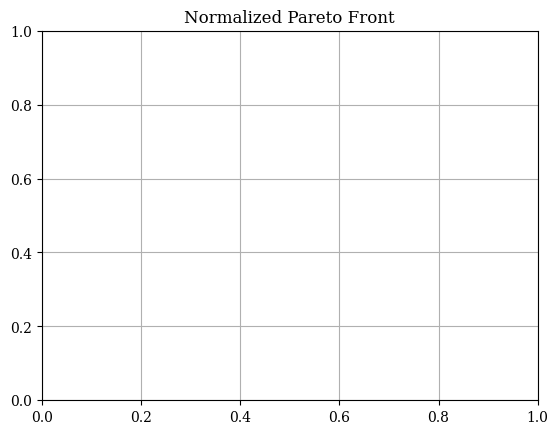

In [1438]:
hv_value, F_norm = calculate_normalized_hypervolume(res.F)
plot_normalized_pareto(F_norm)

In [1439]:
F_norm

array([[1.        , 0.57152901, 0.        , 0.07311871],
       [0.82079503, 0.        , 1.        , 1.        ],
       [0.        , 0.10477126, 0.36454849, 0.01402467],
       ...,
       [0.46774763, 0.57933774, 0.18060201, 0.02167165],
       [0.07240164, 0.17822838, 0.34113712, 0.        ],
       [1.        , 0.57152901, 0.        , 0.07311871]])

In [1384]:
OBJS_NOTIME

['distance', 'green_area_weight', 'foot_class']

In [1388]:


path = ""
for p in path_data[3]['path']:
    path+=p+" "
print(path)

2211349960 2211349953 2211349974 2211349883 2211349888 2211349897 258611683 2211285081 258611722 258611743 258612442 2489155110 258701172 258613871 2622581597 528874095 258701370 258701275 258701301 1235745292 258701362 4594837189 258701288 2269728324 2269728343 2269728356 2269728308 2269728286 6329766037 258611652 6329766036 2629832014 2632671701 259029339 2632672033 2632671652 258701440 258611649 258701551 2313670917 258701498 9896832647 258701105 258701047 2269697362 258613703 258613706 2421121066 2093958029 258611281 2093957930 2125104557 2093957964 2125104561 259029133 2334422783 1235745691 993600630 993600812 993600910 993600699 993600960 993600871 993601006 1235797230 748838649 986413679 748838652 2476375462 1235745272 1235745694 2476375477 1235745383 748838620 1235745815 1110231612 938521024 1235745634 1235745161 1235745588 938521372 938521342 938521209 938521112 938521237 938521174 9529990374 938521086 1378783965 1378783969 938521335 2103380522 938521132 752658270 1836899403 


## Find the optimal solution

### 4.1 Find the best solution based on user preferences

In [1440]:
OBJS_NOTIME

['distance', 'green_area_weight', 'foot_class']

In [1441]:
OBJS_TIME

['pm25']

In [1442]:
USER_PREF #=[0.25, 0.25, 0.25, 0.25]

[0.7, 0.1, 0.1, 0.1]

In [1448]:
weights = np.array(USER_PREF)
score = (F_norm * weights).sum(axis=1)
best_idx = score.argmin()

In [1450]:
best_idx

79

In [1452]:
pareto_solutions[best_idx]

{'distance': 3182.8131723422207,
 'green_area_weight': 3182.8131723422207,
 'foot_class': 359,
 'pm25': 1689.277467129342,
 'path': ['2211349960',
  '2211349953',
  '2211349974',
  '2211349883',
  '2211349888',
  '2211349897',
  '258611683',
  '2211285081',
  '258611722',
  '258611743',
  '258612442',
  '2489155110',
  '258701172',
  '258613871',
  '2622581597',
  '528874095',
  '258701370',
  '258701275',
  '258701301',
  '1235745292',
  '258701362',
  '4594837189',
  '258701288',
  '2269728324',
  '2269728343',
  '2269728356',
  '2269728308',
  '2269728286',
  '6329766037',
  '258611652',
  '6329766036',
  '2629832014',
  '2632671701',
  '259029339',
  '2632672033',
  '2632671652',
  '258701440',
  '258611649',
  '258701551',
  '2313670917',
  '258701498',
  '9896832647',
  '258701105',
  '258701047',
  '2269697362',
  '258613703',
  '258613706',
  '2421121066',
  '2093958029',
  '2093957949',
  '2093957930',
  '2125104557',
  '2093957964',
  '2125104561',
  '259029133',
  '233442278

In [1454]:
res.X[best_idx]

array([204.90012574])

In [1456]:
path = ""
for p in pareto_solutions[best_idx]['path']:
    path+=p+" "
print(path)
B=path

2211349960 2211349953 2211349974 2211349883 2211349888 2211349897 258611683 2211285081 258611722 258611743 258612442 2489155110 258701172 258613871 2622581597 528874095 258701370 258701275 258701301 1235745292 258701362 4594837189 258701288 2269728324 2269728343 2269728356 2269728308 2269728286 6329766037 258611652 6329766036 2629832014 2632671701 259029339 2632672033 2632671652 258701440 258611649 258701551 2313670917 258701498 9896832647 258701105 258701047 2269697362 258613703 258613706 2421121066 2093958029 2093957949 2093957930 2125104557 2093957964 2125104561 259029133 2334422783 1235745691 993600630 993600812 993600910 993600699 993600960 993600871 993601006 1235797230 748838649 986413679 748838652 2476375462 1235745272 1235745694 2476375477 1235745383 748838620 1235745815 10819481304 1235745214 1235745634 1235745161 1235745588 1235745422 9529990366 9529990367 9529990368 9529990369 9529990370 938521174 9529990374 938521086 1378783965 1378783969 938521335 2103380522 938521132 752

### 4.2 Find the solution with the optimal trade-off (points closest to the center of pareto front)

In [1458]:
from numpy.linalg import norm

distances = norm(F_norm, axis=1)
best_idx = distances.argmin()

In [1460]:
pareto_solutions[best_idx]

{'distance': 3195.2313118971715,
 'green_area_weight': 3195.2313118971715,
 'foot_class': 349,
 'pm25': 1724.9215596037322,
 'path': ['2211349960',
  '2211349953',
  '2211349974',
  '2211349883',
  '2211349888',
  '2211349897',
  '258611683',
  '2211285081',
  '258611722',
  '258611743',
  '258612442',
  '2489155110',
  '258701172',
  '258613871',
  '2622581597',
  '528874095',
  '258701370',
  '258701275',
  '258701301',
  '1235745292',
  '258701362',
  '4594837189',
  '258701288',
  '2269728324',
  '2269728343',
  '2269728356',
  '6329753927',
  '6329753928',
  '6329753929',
  '6329766037',
  '258611652',
  '6329766036',
  '2629832014',
  '2632671973',
  '2632671742',
  '259029339',
  '2632672033',
  '2632671652',
  '258701440',
  '258611649',
  '258701551',
  '2313670917',
  '258701498',
  '9896832647',
  '258701105',
  '258701047',
  '2269697362',
  '258613703',
  '258613706',
  '2421121066',
  '2093958029',
  '2093957949',
  '2093957930',
  '2125104557',
  '2093957964',
  '2125104

In [1462]:
path = ""
for p in pareto_solutions[best_idx]['path']:
    path+=p+" "
print(path)
C=path

2211349960 2211349953 2211349974 2211349883 2211349888 2211349897 258611683 2211285081 258611722 258611743 258612442 2489155110 258701172 258613871 2622581597 528874095 258701370 258701275 258701301 1235745292 258701362 4594837189 258701288 2269728324 2269728343 2269728356 6329753927 6329753928 6329753929 6329766037 258611652 6329766036 2629832014 2632671973 2632671742 259029339 2632672033 2632671652 258701440 258611649 258701551 2313670917 258701498 9896832647 258701105 258701047 2269697362 258613703 258613706 2421121066 2093958029 2093957949 2093957930 2125104557 2093957964 2125104561 259029133 2334422783 1235745691 993600630 993600812 993600910 993600699 993600960 993600871 993601006 1235797230 748838649 986413679 748838652 2476375462 1235745272 1235745694 2476375477 1235745383 748838620 1235745815 10819481304 1235745214 1235745634 1235745161 1235745588 1235745422 9529990366 9529990367 9529990368 9529990369 9529990370 938521174 9529990374 938521086 1378783965 1378783969 938521335 21

In [1161]:
A==C

False

### 4.3 Find the best solution based on constraints